In [43]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [45]:
import numpy as np
import pandas as pd

In [46]:
import datetime as dt
from datetime import timedelta 


# Reflect Tables into SQLAlchemy ORM

In [47]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [48]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [49]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [50]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [51]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [52]:
engine.execute('SELECT *fROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [53]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [54]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


# Exploratory Climate Analysis

2016-08-23
('2017-08-23',)


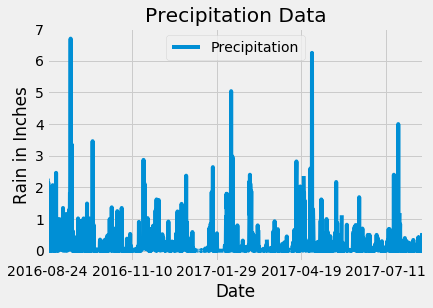

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.set_index('date').head()
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Data")
plt.legend(["Precipitation"])
plt.show()

In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [57]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [58]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")


The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [59]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f'For Station {temps[0][0]} the highest temp recorded was {temps[0][1]} degrees, the lowest temp recorded was {temps[0][2]} degrees, and the average temp was {round(temps[0][3])}.')

For Station USC00519281 the highest temp recorded was 85.0 degrees, the lowest temp recorded was 54.0 degrees, and the average temp was 72.


In [60]:
 #Using the station id from the previous query, calculate the lowest temperature recorded, 
#highest temperature recorded, and average temperature most active station?
best_station = busy_station[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()



[(54.0, 71.66378066378067, 85.0)]

Text(0.5, 1.0, 'Station Analysis')

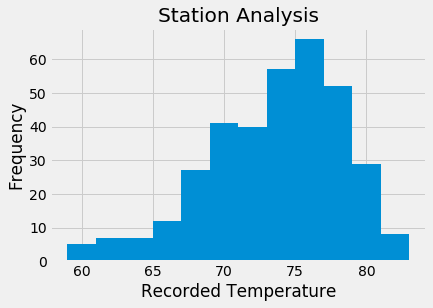

In [61]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis") 

In [62]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

# KNOWN LIMITATION: Because the year is used in the session.query below, the start and end date must be BETWEEN
# ==== The last date in the Measurement table which is: 2017-08-23
# ==== and the first date in the Measurement table which is: 2010-01-01

def calc_temps(start_date_, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()

In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#temp_bar = calc_temps('2016-08-23', '2017-08-23')
#print(temp_bar)

In [63]:
# ==== INPUT REQUIRED: start_date   # the first day of weather query in the format %Y-%m-%d
start_date = input('Enter a start date AS A STRING between 2010-01-01 and 2017-08-23 in the "YYYY-MM-DD" format: ')
# test start_date = '2016-02-28'

# ==== INPUT REQUIRED: end_date     # the last day of the weather query in the format %Y-%m-%d
end_date = input('Enter an end date after the start date and between 2010-01-01 and 2017-08-23 AS A STRING in the "YYYY-MM-DD" format: ')
# test end_date = '2016-03-05'

vacation_calc_temps = calc_temps('{start_date}', '{end_date}')
print('Using weather data from AUG 2016 to AUG 2017,')
print(f'The estimated min, avg, and max temperatures for {start_date} to {end_date} are as follows: ')

# Create a DataFrame with t_min, t_avg, t_max values from vacation_temps
vacation_temps_df = pd.DataFrame(vacation_calc_temps, columns=['min_temp', 'avg_temp', 'max_temp'])
vacation_temps_df

Enter a start date AS A STRING between 2010-01-01 and 2017-08-23 in the "YYYY-MM-DD" format: 2015-05-25
Enter an end date after the start date and between 2010-01-01 and 2017-08-23 AS A STRING in the "YYYY-MM-DD" format: 2015-06-15
Using weather data from AUG 2016 to AUG 2017,
The estimated min, avg, and max temperatures for 2015-05-25 to 2015-06-15 are as follows: 


,min_temp,avg_temp,max_temp
0,56.0,74.719308,87.0


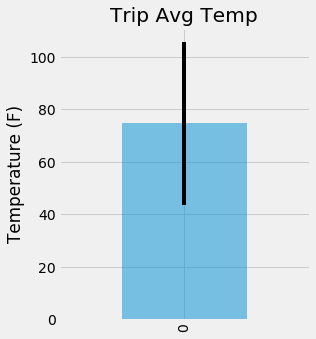

In [64]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vacation_temps_df.plot.bar(y='avg_temp', yerr = (vacation_temps_df['max_temp'] - vacation_temps_df['min_temp']),\
                                title='Trip Avg Temp', alpha=.5, figsize=(4,5), legend=None)
# Set plot properties
plt.ylabel('Temperature (F)')
plt.savefig('temp_avg.png', bbox_inches="tight", dpi = 300)


In [65]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_prcp (prcp_start_date, prcp_end_date):
    """Precipitation information per weather station.
    
    Args:
        prcp_start_date (string): A date string in the format %Y-%m-%d
        prcp_end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in decending order.
    """
    
    sel = [Measurement.station,
             Station.name,
             Station.latitude,
             Station.longitude,
             Station.elevation,
             Measurement.prcp]
      
    return session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= prcp_start_date).\
            filter(Measurement.date <= prcp_end_date).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()


In [66]:
# the first day of weather query in the format '%Y-%m-%d' 
# prcp_start_date = input('Enter a start date AS A STRING between 2010-01-01 and 2017-08-23 in the "YYYY-MM-DD" format: ')
test_start_date = '2016-02-28'
# the last day of the weather query in the format '%Y-%m-%d'
# prcp_end_date = input('Enter an end date AS A STRING between 2010-01-01 and 2017-08-23 in the "YYYY-MM-DD" format: ')
test_prcp_end_date = '2016-03-05'

# calc_prcp_df = pd.DataFrame(calc_prcp('{prcp_start_date}', '{prcp_end_date}'), columns=['station_id','station name', 'latitude', 'longitude', 'elevation', 'precipitation'])
calc_prcp_df = pd.DataFrame(calc_prcp('2016-02-28', '2016-03-05'), columns=['station_id','station_name', 'latitude', 'longitude', 'elevation', 'precipitation'])

calc_prcp_df

,station_id,station_name,latitude,longitude,elevation,precipitation
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.0
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.0
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.0
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.0
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.0
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [67]:
# Average rainfall per weather station during the range of dates
start_date_dt = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = dt.datetime.strptime(end_date, '%Y-%m-%d')

session.query(Measurement.station, func.avg(Measurement.prcp)). \
            filter(Measurement.date.between(start_date_dt, end_date_dt)). \
            group_by(Measurement.station). \
            order_by(func.avg(Measurement.prcp).desc()).all()

[('USC00516128', 0.3710526315789473),
 ('USC00519281', 0.20095238095238094),
 ('USC00513117', 0.1361111111111111),
 ('USC00514830', 0.07933333333333334),
 ('USC00519523', 0.05),
 ('USC00517948', 0.02),
 ('USC00511918', 0.001),
 ('USC00518838', 0.0),
 ('USC00519397', 0.0)]

In [68]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def vacation_daily_normals_temp(vacation_start_date, vacation_end_date):
    """vacation daily normals temperature.
    Args:
        vacation_start_date (str): A date string in the format '%Y-%m-%d'
        vacation_end_date (str): A date string in the format '%Y-%m-%d'
    Returns:
        A list of tuples containing the date and daily normals for temperatures for temp_min, temp_avg, and temp_max
    """       
    sel = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    return session.query(*sel).filter(func.strftime('%m-%d', Measurement.date) >= (vacation_start_date[5:])).\
                                       filter(func.strftime('%m-%d', Measurement.date) <= (vacation_end_date[5:])).\
                                       group_by(func.strftime('%m-%d', Measurement.date)).all()

In [39]:
# ==== INPUT REQUIRED: vacation_start_date   # the first day of weather query in the format '%Y-%m-%d' 
# vacation_start_date = input('Enter a start date AS A STRING between 2010-01-01 and 2017-08-23 in the "YYYY-MM-DD" format: ')
vacation_start_date = '2017-02-28'

# ==== INPUT REQUIRED: vacation_end_date     # the last day of the weather query in the format '%Y-%m-%d'
# # vacation_end_date = input('Enter a start date AS A STRING between 2010-01-01 and 2017-08-23 in the "YYYY-MM-DD" format: ')
vacation_end_date = '2017-03-05'

vacation_daily_normals_temp_df = pd.DataFrame(vacation_daily_normals_temp('2017-02-28', '2017-03-05'), columns= ('date', 'temp_min', 'temp_avg', 'temp_max'))
vacation_daily_normals_temp_df

,date,temp_min,temp_avg,temp_max
0,2016-02-28,65.0,70.655172,80.0
1,2016-02-29,67.0,71.733333,79.0
2,2014-03-01,64.0,70.032787,76.0
3,2015-03-02,61.0,70.366667,78.0
4,2017-03-03,60.0,70.068966,78.0
5,2017-03-04,57.0,69.272727,77.0
6,2016-03-05,60.0,67.890909,76.0


In [69]:
# Create a list of vacation dates
# the following makes use of datetime and requires dependencies to include import datetime as dt and import timedelta
start = dt.datetime.strptime(vacation_start_date, "%Y-%m-%d")
end = dt.datetime.strptime(vacation_end_date, "%Y-%m-%d")+ timedelta(days=1)
vacation_dates = \
    [start + dt.timedelta(days=x) for x in range(0, ((end-start)).days)]

print(list(vacation_dates))

[datetime.datetime(2017, 2, 28, 0, 0), datetime.datetime(2017, 3, 1, 0, 0), datetime.datetime(2017, 3, 2, 0, 0), datetime.datetime(2017, 3, 3, 0, 0), datetime.datetime(2017, 3, 4, 0, 0), datetime.datetime(2017, 3, 5, 0, 0)]


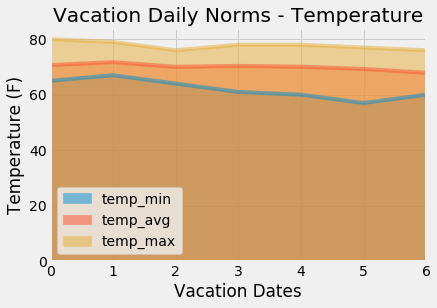

In [71]:
# Plot the daily normals as an area plot with `stacked=False`
vacation_daily_normals_temp_df.plot(kind='area', alpha=.5, stacked=False, x_compat=True, title='Vacation Daily Norms - Temperature')

# Set plot properties
plt.ylabel('Temperature (F)')
plt.xlabel('Vacation Dates')
plt.savefig('Vacation_Daily_Normals_Temp.png')